In [1]:
import json
import pandas as pd
# Opening JSON file
f = open('/home/ferdinand_t/data/CMS_2010_to_June_2022_ENGLISH.json')
# returns JSON object as
# a dictionary
data = json.load(f)
df = pd.DataFrame.from_dict(data)

In [2]:
df['firstKeyword'] = df['keywords'].apply(lambda x: x[0]['name'] if len(x) != 0 else None)
# #df['secondKeyword'] = df['keywords'].apply(lambda x: x[1]['name'] if len(x) > 1 else None)
# #df['thirdKeyword'] = df['keywords'].apply(lambda x: x[2]['name'] if len(x) > 2 else None)
# #df['fourthKeyword'] = df['keywords'].apply(lambda x: x[3]['name'] if len(x) > 3 else None)

df['cleanFocusCategory'] = df['thematicFocusCategory'].apply(lambda x: x['name'] if x is not None else x)

# #df = df[['firstKeyword', 'secondKeyword', 'thirdKeyword', 'fourthKeyword', 'thematicFocusCategory', 'cleanFocusCategory']]

df = df[['firstKeyword', 'keywordStrings', 'cleanFocusCategory']]

df_clean = df.copy()
df_clean = df_clean.dropna()
# df_clean['cleanKeywordStrings'] = [' '.join(map(str, l)) for l in df_clean['keywordStrings']]

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [4]:
df_clean_dummy = pd.get_dummies(df_clean['cleanFocusCategory'])
df_clean_dummy.shape

(79913, 46)

In [5]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df_clean['keywordStrings'][-55000:-1].astype(str), df_clean_dummy[-55000:-1], df_clean.index[-55000:-1], test_size=0.33, random_state=0, stratify=df_clean_dummy[-55000:-1] )

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words=None)
features_train = tfidf.fit_transform(X_train)
labels_train = y_train

#model.fit(features_train, labels_train)

features_test = tfidf.transform(X_test)
labels_test = y_test

In [6]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM

input_dim = features_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(20, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.6))
model.add(layers.Dense(46, activation='softmax'))

2023-03-18 21:58:52.275276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 21:58:53.096954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-18 21:58:53.096976: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-18 21:58:55.059135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                505860    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 46)                966       
                                                                 
Total params: 506,826
Trainable params: 506,826
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(features_train.toarray(), labels_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(features_test.toarray(), labels_test),
                    batch_size=5)

2023-03-18 21:59:09.470434: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3727939632 exceeds 10% of free system memory.
2023-03-18 21:59:54.374616: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1836199200 exceeds 10% of free system memory.


In [9]:
from keras.backend import clear_session
clear_session()

In [10]:
# loss, acc = model.evaluate(features_train.toarray(), labels_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(acc))
# loss, acc = model.evaluate(features_test.toarray(), labels_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(acc))

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

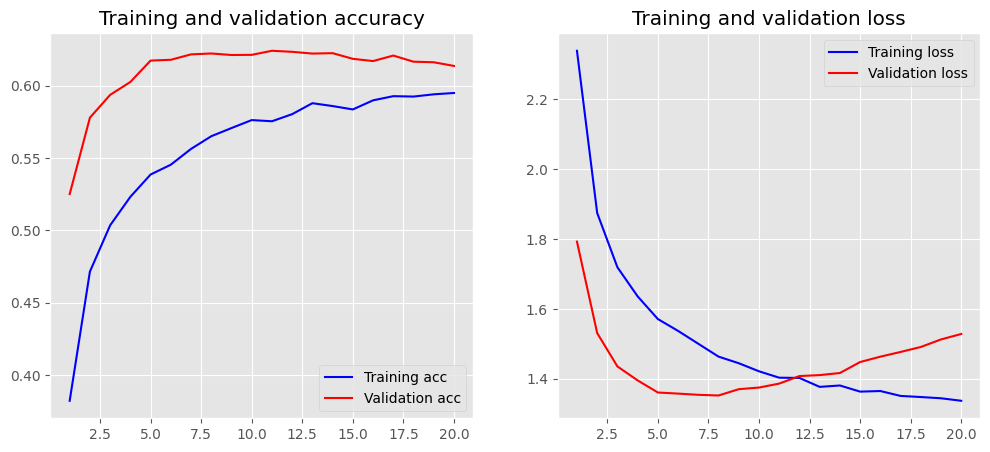

In [12]:
plot_history(history)

In [13]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [15]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df_clean['keywordStrings'][-37000:-1].astype(str), df_clean_dummy[-37000:-1], df_clean.index[-37000:-1], test_size=0.33, random_state=0, stratify=df_clean_dummy[-37000:-1])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words=None)
features_train = tfidf.fit_transform(X_train)
#labels_train = y_train

#model.fit(features_train, labels_train)

features_test = tfidf.transform(X_test)
#labels_test = y_test

In [19]:
x_train = features_train
x_test = features_test

num_classes = y_train.shape[1]

batch_size = 1000
epochs = 7

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(features_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history_2 = model.fit(x_train.toarray(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

: 

: 

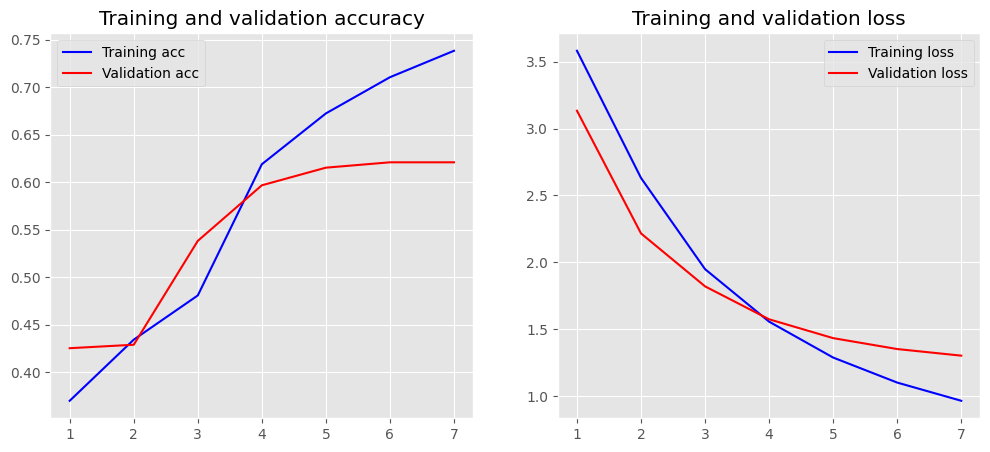

In [ ]:
plot_history(history_2)

In [ ]:
score = model.evaluate(x_test.toarray(), y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2023-03-18 22:18:22.084754: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 978655920 exceeds 10% of free system memory.


13/13 [==============================] - 2s 119ms/step - loss: 1.2732 - accuracy: 0.6355
Test accuracy: 0.635462760925293
